In [50]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

DEBUG = False
TRAIN_MODEL = False
INFER_TEST = True
ONE_FOLD_ONLY = True
COMPUTE_LSTM_IMPORTANCE = True

sns.set_style("whitegrid")
sns.set_palette("Paired")

In [51]:
kaup = pd.read_csv('serbyli_all_variables_MEAN.csv',
    usecols=('date', #'kaupverd', 'fasteignamat', 
    'byggar', 'einflm', 'lod_flm','verd_m2',
     #  'fjöldi_kaupsamninga', 'auglyst_serbyli', 'solutimi', 'Verðtryggð lán',
      # 'erlend_lan', 'Óverðtryggð lán', 'overdtryggt', 'verdtryggt',
       #'visitala_rvk_%', 'verdbolga_%')
    ))
indep = pd.read_csv('20_independent_variables_LSTM.csv', parse_dates=True)

In [52]:
df = pd.merge(kaup,indep, how='left', on='date')

In [53]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,date,byggar,einflm,lod_flm,verd_m2,fjöldi_kaupsamninga,auglyst_serbyli,auglyst_fjolbyli,solutimi,Verðtryggð lán,...,visitala_rvk_%,verdbolga_%,Reykjavík,Kópavogur,Garðabær,Hafnarfjörður,Mosfellsbær,"Eigendur, skuldlaust",Eigendur m. lán,"Leigjendur, alls"
0,2006-04-01,2003.000000,290.700000,632.800000,223.598211,598.40,0.48,2.05,6.21,87.42,...,1.2,1.070205,0.426995,0.421847,0.472678,0.390313,0.354208,17.025,65.85,17.125
1,2006-06-01,1977.243243,173.518919,1695.443243,222.630116,472.74,0.48,2.05,6.21,87.20,...,0.6,1.001669,0.427300,0.421320,0.476982,0.393491,0.356153,16.375,66.55,17.075
2,2006-07-01,1973.343750,187.431250,1315.950000,231.063339,436.96,0.48,2.05,6.21,87.09,...,-1.7,0.413223,0.427453,0.421056,0.479134,0.395080,0.357125,16.050,66.90,17.050
3,2006-08-01,1966.000000,176.651724,991.982759,226.015105,406.92,0.48,2.05,6.21,86.98,...,2.4,0.288066,0.427606,0.420792,0.481286,0.396669,0.358097,15.725,67.25,17.025
4,2006-09-01,1972.345455,173.292727,1437.796364,224.425115,354.73,0.49,2.06,7.19,86.87,...,0.7,0.615511,0.427759,0.420528,0.483439,0.398258,0.359070,15.400,67.60,17.000


In [54]:
fm2 = df['verd_m2']
df.drop('verd_m2', axis=1, inplace=True)
df.insert(1, 'verd_m2', fm2)
df.tail()

,date,verd_m2,byggar,einflm,lod_flm,fjöldi_kaupsamninga,auglyst_serbyli,auglyst_fjolbyli,solutimi,Verðtryggð lán,...,visitala_rvk_%,verdbolga_%,Reykjavík,Kópavogur,Garðabær,Hafnarfjörður,Mosfellsbær,"Eigendur, skuldlaust",Eigendur m. lán,"Leigjendur, alls"
188,2022-01-01,522.140885,1980.486842,193.510526,1551.919737,598.23,0.12,0.35,0.79,40.28,...,1.7,0.161253,0.427761,0.386199,0.382488,0.368074,0.341139,20.4,56.5,21.7
189,2022-02-01,529.559932,1978.320000,202.034000,1117.332000,516.03,0.13,0.32,0.88,40.28,...,2.5,1.264949,0.427761,0.386199,0.382488,0.368074,0.341139,20.4,56.5,21.7
190,2022-03-01,590.712389,1979.960784,185.774510,1191.400000,516.03,0.12,0.38,0.88,40.28,...,3.1,0.817624,0.427761,0.386199,0.382488,0.368074,0.341139,20.4,56.5,21.7
191,2022-04-01,585.286590,1982.400000,180.857778,1037.535556,516.03,0.12,0.38,0.88,40.28,...,2.7,0.991214,0.427761,0.386199,0.382488,0.368074,0.341139,20.4,56.5,21.7
192,2022-05-01,569.803711,1979.475000,190.230000,1498.110000,516.03,0.12,0.38,0.88,40.28,...,2.7,0.423823,0.427761,0.386199,0.382488,0.368074,0.341139,20.4,56.5,21.7


In [55]:
df.shape

(193, 24)

In [56]:
train_dates = pd.to_datetime(df['date'])
print(train_dates.tail(4))

189   2022-02-01
190   2022-03-01
191   2022-04-01
192   2022-05-01
Name: date, dtype: datetime64[ns]


In [57]:
#Variables for training
cols = list(df)[1:]
#Date is not used in training. 
print(cols)

['verd_m2', 'byggar', 'einflm', 'lod_flm', 'fjöldi_kaupsamninga', 'auglyst_serbyli', 'auglyst_fjolbyli', 'solutimi', 'Verðtryggð lán', 'erlend_lan', 'Óverðtryggð lán', 'overdtryggt', 'verdtryggt', 'visitala_rvk_%', 'verdbolga_%', 'Reykjavík', 'Kópavogur', 'Garðabær', 'Hafnarfjörður', 'Mosfellsbær', 'Eigendur, skuldlaust', 'Eigendur m. lán', 'Leigjendur, alls']


In [58]:
df_for_training = df[cols].astype(float)

In [59]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [60]:
trainX = []
trainY = []

n_future = 2   # Number of months we want to look into the future based on the past months.
n_past = 2  # Number of past months we want to use to predict the future.

In [61]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (190, 2, 23).
trainY shape == (190, 1).


In [62]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 64)             22528     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34,977
Trainable params: 34,977
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
6/6 [==============================] - 3s 133ms/step - loss: 0.5131 - val_loss: 4.6002
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4107 - val_loss: 4.2565
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3119 - val_loss: 3.7305
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.2240 - val_loss: 2.8945
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.1583 - val_loss: 1.6666
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0930 - val_loss: 0.6979
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0702 - val_loss: 0.7400
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0544 - val_loss: 0.8249
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0436 - val_loss: 0.6911
Epoch 10/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0451 - val_loss: 0.4802
Epoch 11/100
6/6 [=======

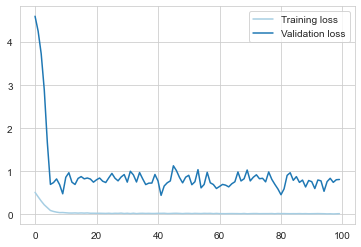

In [63]:
history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [64]:
n_past = 170
n_days_for_prediction=173  #4 months

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='m').tolist()
print(predict_period_dates)

[Timestamp('2008-04-30 00:00:00', freq='M'), Timestamp('2008-05-31 00:00:00', freq='M'), Timestamp('2008-06-30 00:00:00', freq='M'), Timestamp('2008-07-31 00:00:00', freq='M'), Timestamp('2008-08-31 00:00:00', freq='M'), Timestamp('2008-09-30 00:00:00', freq='M'), Timestamp('2008-10-31 00:00:00', freq='M'), Timestamp('2008-11-30 00:00:00', freq='M'), Timestamp('2008-12-31 00:00:00', freq='M'), Timestamp('2009-01-31 00:00:00', freq='M'), Timestamp('2009-02-28 00:00:00', freq='M'), Timestamp('2009-03-31 00:00:00', freq='M'), Timestamp('2009-04-30 00:00:00', freq='M'), Timestamp('2009-05-31 00:00:00', freq='M'), Timestamp('2009-06-30 00:00:00', freq='M'), Timestamp('2009-07-31 00:00:00', freq='M'), Timestamp('2009-08-31 00:00:00', freq='M'), Timestamp('2009-09-30 00:00:00', freq='M'), Timestamp('2009-10-31 00:00:00', freq='M'), Timestamp('2009-11-30 00:00:00', freq='M'), Timestamp('2009-12-31 00:00:00', freq='M'), Timestamp('2010-01-31 00:00:00', freq='M'), Timestamp('2010-02-28 00:00:00'

In [65]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

6/6 [==============================] - 0s 2ms/step


In [66]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [67]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'verd_m2':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

C:\Users\halld\AppData\Local\Temp\ipykernel_5920\279094052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])
c:\Anaconda\envs\Deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Anaconda\envs\Deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyw

<AxesSubplot:xlabel='date', ylabel='verd_m2'>

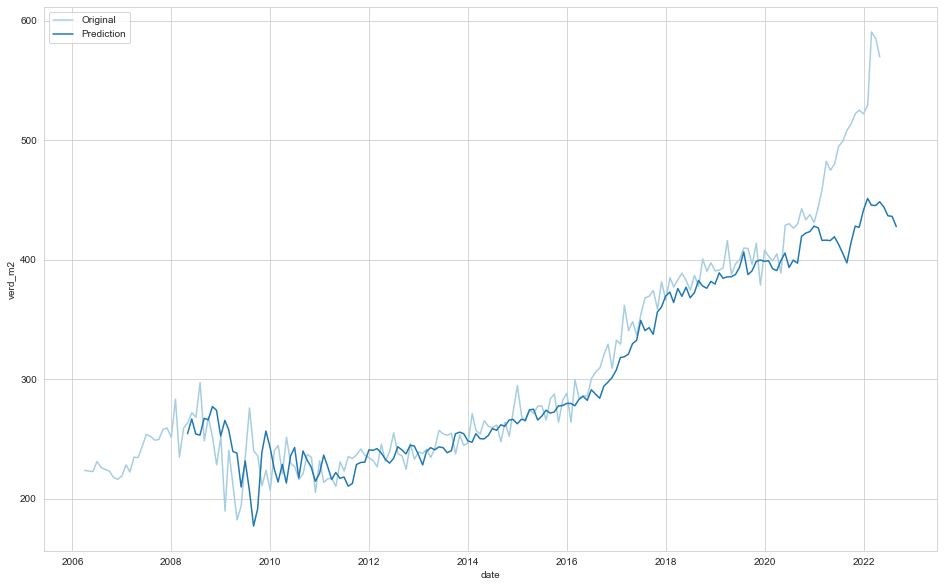

In [68]:
original = df[['date', 'verd_m2']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2006-1-1']

plt.figure(figsize=(16,10))
sns.lineplot(original['date'], original['verd_m2'], label='Original')
sns.lineplot(df_forecast['date'], df_forecast['verd_m2'], label='Prediction')

In [69]:
EPOCH = 50
BATCH_SIZE = 32
NUM_FOLDS = 5

# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# GET GPU STRATEGY
gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        K.clear_session()
        
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        
        checkpoint_filepath = f"folds{fold}.hdf5"
        if TRAIN_MODEL:
            model = keras.models.Sequential([
                keras.layers.Input(shape=train.shape[-2:]),
                keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
                keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
                keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
                keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
                keras.layers.Dense(128, activation='selu'),
                keras.layers.Dense(1),
            ])
            model.compile(optimizer="adam", loss="mae")

            lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
            es = EarlyStopping(monitor="val_loss", patience=60, verbose=1, mode="min", restore_best_weights=True)
            sv = keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch',
                options=None
            )
            model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es, sv])
            
        else:
            model = keras.models.load_model('../input/finetune-of-tensorflow-bidirectional-lstm/'+checkpoint_filepath)

        if INFER_TEST:
            print(' Predicting test data...')
            test_preds.append(model.predict(test,verbose=0).squeeze().reshape(-1, 1).squeeze())
                    
        if COMPUTE_LSTM_IMPORTANCE:
            results = []
            print(' Computing LSTM feature importance...')
            
            # COMPUTE BASELINE (NO SHUFFLE)
            oof_preds = model.predict(X_valid, verbose=0).squeeze() 
            baseline_mae = np.mean(np.abs( oof_preds-y_valid ))
            results.append({'feature':'BASELINE','mae':baseline_mae})           

            for k in tqdm(range(len(COLS))):
                
                # SHUFFLE FEATURE K
                save_col = X_valid[:,:,k].copy()
                np.random.shuffle(X_valid[:,:,k])
                        
                # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
                oof_preds = model.predict(X_valid, verbose=0).squeeze() 
                mae = np.mean(np.abs( oof_preds-y_valid ))
                results.append({'feature':COLS[k],'mae':mae})
                X_valid[:,:,k] = save_col
         
            # DISPLAY LSTM FEATURE IMPORTANCE
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('mae')
            plt.figure(figsize=(10,20))
            plt.barh(np.arange(len(COLS)+1),df.mae)
            plt.yticks(np.arange(len(COLS)+1),df.feature.values)
            plt.title('LSTM Feature Importance',size=16)
            plt.ylim((-1,len(COLS)+1))
            plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
                     label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
            plt.xlabel(f'Fold {fold+1} OOF MAE with feature permuted',size=14)
            plt.ylabel('Feature',size=14)
            plt.legend()
            plt.show()
                               
            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('mae',ascending=False)
            df.to_csv(f'lstm_feature_importance_fold_{fold+1}.csv',index=False)
                               
        # ONLY DO ONE FOLD
        if ONE_FOLD_ONLY: break

NameError: name 'train' is not defined